# Rede Neural Recorrente - Série Temporal com 1 previsor

In [116]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline

## Obter os dados de treino

In [117]:
data_train = pd.read_csv("petr4-treinamento.csv")

In [118]:
data_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


## Pré-Processamento dos dados de treino - Tratamento dos dados Ausentes

In [119]:
# Só existem 3 valores ausentes nos dados de treino
data_train.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [120]:
# Tamanho original do dataset de treino
data_train.shape

(1245, 7)

In [121]:
# Como apenas 3 linhas têm valores ausentes optou-se por apagar essas linhas.
data_train = data_train.dropna()

In [122]:
# Confirmação de ter-se removido apenas 3 linhas
data_train.shape

(1242, 7)

In [123]:
# Confirmação da anão existencia de valores nulos
data_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Pré-Processamento dos dados de treino- Normalização das Variaveis

In [124]:
from sklearn.preprocessing import MinMaxScaler

In [125]:
# Nas redes neurais recorrentes, como cada neuronio aponta para ele mesmo(possui loops), ou seja, o valor da função de ativação 
# é passado para as camadas subsequentes e também para a própria camada. Assim sendo a rede neural recorrente pode ser 
# considerada como várias cópias de si mesma. 
# Utiliza-se a normalização para que o poder computacional necessário não seja tão grande.

# StandardScaler: Assume que as variaveis seguem uma distribuição normal. Após a normalização o desvio padrão das variaveis
# será 1 e a media 0. É util quando se têm valores negativos. Após a sua aplicação todas as variaveis têm a mesma escala.

# MinMaxScaler: Espreme as variaveis numa escala de -1 a 1 (se existirem valores negativos). É utilizado quando a distribuição
# não é gausiana. Funciona bem se o desio padrão for pequeno e é sensivel a outliers.

scaler = MinMaxScaler(feature_range=(0,1))

In [126]:
# Normalizar a variavel de entrada
# Apenas se vai normalizar a variavel Open, porque irá ser a unica variavel de entrada utilizada para fazer o treino do modelo.
scaler.fit(data_train.drop(["Date", "High", "Low", "Close", "Adj Close", "Volume"], axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [127]:
# Array com a variavel Open normalizada
open_norm_train = scaler.fit_transform(data_train.drop(["Date", "High", "Low", "Close", "Adj Close", "Volume"], axis=1))

## Divisão dos dados de treino

In [128]:
# Utilizar apenas o preço de abertura para prever o preço das acções.
open_norm_train[0:5]

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       [0.78875969],
       [0.77083338]])

In [129]:
# Prever o preço das acções com base nos preços de abertura nos 90 dias anteriores.

X_train = [] # vector com os preços nos 90 dias anteriores.
y_train = [] # vector com o preço da acção no dia 91.

In [130]:
# Só é possivel prever o preço das acções desde o dia 90 até ao dia 1242. Porque só se tem registro de 1242 dias e 
# estabeleceu-se como critério utilizar os 90 dias anteriores para fazer uma previsão.

for i in range(90, 1242):
    X_train.append(open_norm_train[i-90:i,0])
    y_train.append(open_norm_train[i, 0])

In [131]:
# Converter os vectores em arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [132]:
X_train.shape

(1152, 90)

In [133]:
# X_train[0]: preço nos primeiros 90 dias. Utilizado para prever o preço no dia 91.
# X_train[1]: preços entre o dia 1 e dia 91. Utilizado para prever o preço no dia 92.
# X_train[2]: preço entre o dia 2 e dia 92. Utilizado para prever o preço no dia 93.

X_train[0,84:89]

array([0.77761628, 0.77325581, 0.7562984 , 0.74273261, 0.74127907])

In [134]:
# y_train[0:1]: preço no dia 91.
# y_train[1:2] preço no dia 92.
y_train[2:3]

array([0.77470935])

In [135]:
# A camada de entrada tem de ser um tensor 3d (input_shape, timesteps, input_dim)
# input_shape: 1152 registros. Número de registros totais
# timesteps: 90 registros. Número de registros utilizados para fazer a previsão.
#input_dim: 1 indicador(apenas 1 variavel de entrada)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [136]:
X_train.shape

(1152, 90, 1)

## Modelo Rede Neural Recorrente

In [137]:
# sequential - A informação é passada de uma camada para a camada seguinte

#-------------------------------------------------------------------------------------------------------------------------------
# Camada LSTM

# LSTM - Long short term memory. AS redes neurais simples têm dificuldade em "aprender" alguns tipos de padrões mais complexos.
# Nesses casos pode-se utilizar o tipo de rede neural recorrente LSTM que aprende "dependencias" de longo prazo.

# As redes neurais recorrentes simples armazenam as informações no tempo atraves de loops( o neuronio apenas aponta para ele 
# mesmo e para a camada seguinte). Isto permte que a informação persista.
# As redes neurais recorrentes LSTM para alem disso têm celulas de memoria e manipulam essas celulas de modo a filtrar e 
# armazenar a informação importante nessas celulas.

# As redes neurais recorrentes ajudam no problema do gradiente desaparecendo(vanish gradient). No ajuste dos pesos ao se
# utilizar a descida do gradiente e a sua actualização atraves de backpropagation em primeiro faz-se os calculos da camada
# de entrada para a camada de saida. Os pesos são depois actalizados a partir da camada de saida para a camada de entrada. Os
# pesos vão sendo actualizados utilizando o learning rate(maiores alterações nas 1ªs camadas). Caso se tenha muitos loops
# as ultimas actualizações do gradiente são muito pequenas, o que faz com que o peso não tenha alteração no seu valor.

# Número de celulas de memoria(units): Número de vezes(loops) em que a informação é passada ao mesmo neuronio e a camada 
# seguinte (numero de cópias da camada). Deve ser um valor alto para adicinonar mais dimensionalidade e decorar a tendencia ao 
# longo do tempo.

# Return_sequence: True. Apenas se utilizada quando se tem mais de uma camada LSTM. Indica que a informação será passada para a
# camada seguinte.

# input_shape: Número de registros utilizados para fazer a previsão(90) e número de variaveis de entrada(1).
#-------------------------------------------------------------------------------------------------------------------------------
# Camada densa

# Todos os neuronios da ultima camada( segunda camada LSTM) estão conectados à camada de saida. Nas camadas LSTM isso tambem
# acontece.

# units: 1. Só se quer prever o valor Open.
# activation: linear. É um problema de regressão. Como os valores estão normalizados(entre 0 e 1) caso se utiliza-se a função
# sigmoid tambem se retornaria valores entre 0 e 1.
#-------------------------------------------------------------------------------------------------------------------------------

model = models.Sequential()
model.add(layers.LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=1, activation="linear"))

## Compilação e Ajuste do modelo RNN

In [138]:
# optimizer: pode-se utilizar o RMSprop, indicado para redes neurais recorrentes, ou o adam que obtem resultados semelhantes.
# loss: mean_squared_error é o parametro utilizado para problemas de regressão.

# Compilação do modelo
model.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=["mean_absolute_error"])

In [139]:
# Ajustar os dados de entrada de treino aos dados de saida para treinar o modelo.
model.fit(X_train, y_train, epochs=50, batch_size=32)

Train on 1152 samples
Epoch 1/50
1152/1152 [==============================] - 10s 9ms/sample - loss: 0.0352 - mean_absolute_error: 0.1360
Epoch 2/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0149 - mean_absolute_error: 0.0935
Epoch 3/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0127 - mean_absolute_error: 0.0877
Epoch 4/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0120 - mean_absolute_error: 0.0829
Epoch 5/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0100 - mean_absolute_error: 0.0769
Epoch 6/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0092 - mean_absolute_error: 0.0740
Epoch 7/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0083 - mean_absolute_error: 0.0707
Epoch 8/50
1152/1152 [==============================] - 8s 7ms/sample - loss: 0.0077 - mean_absolute_error: 0.0674
Epoch 9/50
1152/1152 [==============================] - 8

## Obter os dados de teste

In [140]:
data_test = pd.read_csv("petr4-teste.csv")

In [141]:
data_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [142]:
data_test.shape

(22, 7)

In [143]:
# data_train tem os dados desde 2013-01-02 até 2017-12-29
# data_teste tem os dados desde 2018-01-02 até 2018-01-31
# data tem dos dados desde 2013-01-02 até 2018-01-31

data = pd.concat((data_train["Open"], data_test["Open"]), axis=0)

In [144]:
# dados desde 2017-08-28 até 2018-01-31
data_open_test = data[len(data)-len(data_test)-90:].values

In [145]:
# 22+90=112 dias de preços
# O X_test contem os 22 dias da base de dados de teste mais os 90 dias anteriores. Esses 90 dias anteriores são necessários 
# para se poderem fazer previssões.
len(data_open_test)

112

In [146]:
data_open_test.shape

(112,)

In [147]:
# Alterar a forma do array para poder ser utilizada a normalização
# -1 significa que o array não tem colunas
data_open_test = data_open_test.reshape(-1,1)

In [148]:
data_open_test.shape

(112, 1)

## Pré-Processamento dos dados de teste - Normalização das Variaveis

In [149]:
# Array com a variavel Open normalizada.
# Não é necessário o fit_transform porque os dados já foram ajustados anteriormente na outra normalização.

open_norm_test = scaler.transform(data_open_test)

## Divisão dos dados de teste

In [150]:
X_test = []
y_test = []

In [151]:
for i in range(90, 112):
    X_test.append(open_norm_test[i-90:i, 0])
    y_test.append(open_norm_test[i,0])

In [152]:
# Converter os vectores em arrays
X_test, y_test = np.array(X_test), np.array(y_test)

In [153]:
# X_test[0]: preço nos primeiros 90 dias. Utilizado para prever o preço no dia 91.
# X_test[1]: preços entre o dia 1 e dia 91. Utilizado para prever o preço no dia 92.
# X_test[2]: preço entre o dia 2 e dia 92. Utilizado para prever o preço no dia 93.

X_test[1,89]

0.5809109011627908

In [154]:
# y_test[0:1]: preço no dia 91.
# y_test[1:2] preço no dia 92.

y_test[0:1]

array([0.5809109])

In [155]:
# A camada de entrada tem de ser um tensor 3d (input_shape, timesteps, input_dim)
# input_shape: 22 registros. Número de registros totais de teste
# timesteps: 90 registros. Número de registros utilizados para fazer a previsão.
#input_dim: 1 indicador(apenas 1 variavel de entrada)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [156]:
X_test.shape

(22, 90, 1)

## Previsão e Avaliação do Modelo RNN

In [157]:
# Prever os dados de teste para avaliar o modelo
predictions = model.predict(X_test)

In [158]:
# Reverter a normalização do X_test para comparar os valores das acções
predictions = scaler.inverse_transform(predictions)

In [159]:
# Reverter a normalização do y_test para comparar os valores das acções
# Alterar a forma do array para poder reverter a normalização
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [168]:
pd.DataFrame({"Predictions": predictions[:,0], "y_test":y_test[:,0]}).head()

,Predictions,y_test
0,16.003515,16.190001
1,16.085693,16.490000
2,16.214394,16.780001
3,16.440117,16.700001
4,16.633940,16.740000


### Avaliação do Modelo

In [161]:
from sklearn import metrics

In [162]:
# O MSE é muito mais elevado porque penaliza os desvios grandes(são elevados ao quadrado).
# O MAE de 0.36 significa que o preço das acções varia +- 0.36 reais. 
print("MAE", metrics.mean_absolute_error(y_test, predictions))
print("MSE", metrics.mean_squared_error(y_test, predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE 0.36132987777987435
MSE 0.22163797579401148
RMSE 0.47078442603171516


In [163]:
predictions.mean()

17.513216

In [164]:
y_test.mean()

17.87454563636364

### Resíduos

Text(0.5, 0, 'y_test-predictions')

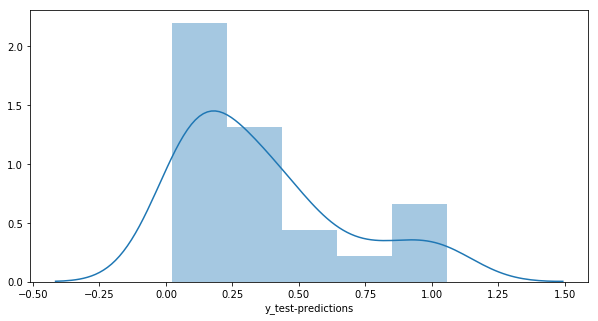

In [165]:
# Histograma de Residuos 
# O gráfico não parece aproximar-se de uma distriuição normal, onde os residuos são proximos de zero.

plt.figure(figsize=(10,5))
sns.distplot(y_test-predictions)
plt.xlabel("y_test-predictions")

### Gráfico preço real vs preço previsto

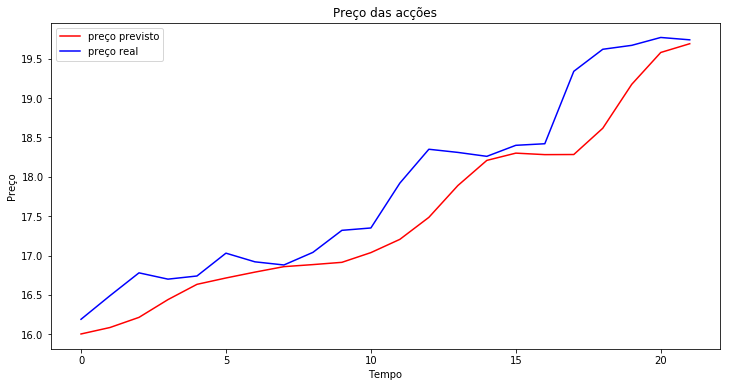

In [166]:
plt.figure(figsize=(12,6))
plt.plot(predictions, color="red", label="preço previsto")
plt.plot(y_test, color="blue", label="preço real")
plt.title("Preço das acções")
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.legend()
plt.show()